# Defense comparison: Original vs PhotoGuard vs DiffusionGuard vs DiffVax

This notebook compares **edited** results for the same prompt across four conditions:

1. **Edited (original)** — inpainting applied to the original image  
2. **Edited (PhotoGuard)** — same edit applied to the PhotoGuard-protected image (`outputs/pg_adv`)  
3. **Edited (DiffusionGuard)** — same edit applied to the DiffusionGuard-protected image (`outputs/dg_adv`)  
4. **Edited (DiffVax)** — same edit applied to the DiffVax-protected image (`outputs/edited_diffvax_adv`)

All four edited images are shown in a single row for direct comparison.

## Setup

In [ ]:
import os
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

from diffvax.attack import Attack
from diffvax.immunization import DiffVaxImmunization
from diffvax.utils import (
    set_seed_lib,
    load_image_from_path,
    prepare_mask_and_masked_image,
    recover_image,
)

to_pil = T.ToPILImage()

## Configuration

In [2]:
# Image to compare (used for all output filenames)
IMAGE_NAME = "image_1"

# Paths: original image and mask (for running edits on pg_adv / dg_adv)
IMAGE_PATH = project_root / "data" / "validation" / "images" / f"{IMAGE_NAME}.png"
MASK_PATH = project_root / "data" / "validation" / "masks" / f"mask_{IMAGE_NAME}.png"
CHECKPOINT_PATH = project_root / "checkpoints" / "diffvax_trained.pth"

# Output folders: protected images and edited results
OUTPUTS = project_root / "outputs"
EDITED_ORIG_DIR = OUTPUTS / "edited_orig"
PG_ADV_DIR = OUTPUTS / "pg_adv"
DG_ADV_DIR = OUTPUTS / "dg_adv"
EDITED_DIFFVAX_DIR = OUTPUTS / "edited_diffvax_adv"

# Edit prompt used for comparison
EDIT_PROMPT = "a person in an alley"

# Reproducibility
SEED = 5

# Diffusion model for running edits
ATTACK_MODEL = "runwayml/stable-diffusion-inpainting"

## Load models

In [3]:
print("Loading diffusion model and immunization checkpoint...")
attack_model = Attack(ATTACK_MODEL)
immunization_mdl = DiffVaxImmunization(
    attack_model,
    config={"learning_rate": 3.0},
    load_existing=True,
    load_path=CHECKPOINT_PATH,
)
print("Done.")

Loading diffusion model and immunization checkpoint...


unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Done.


## Load image and mask

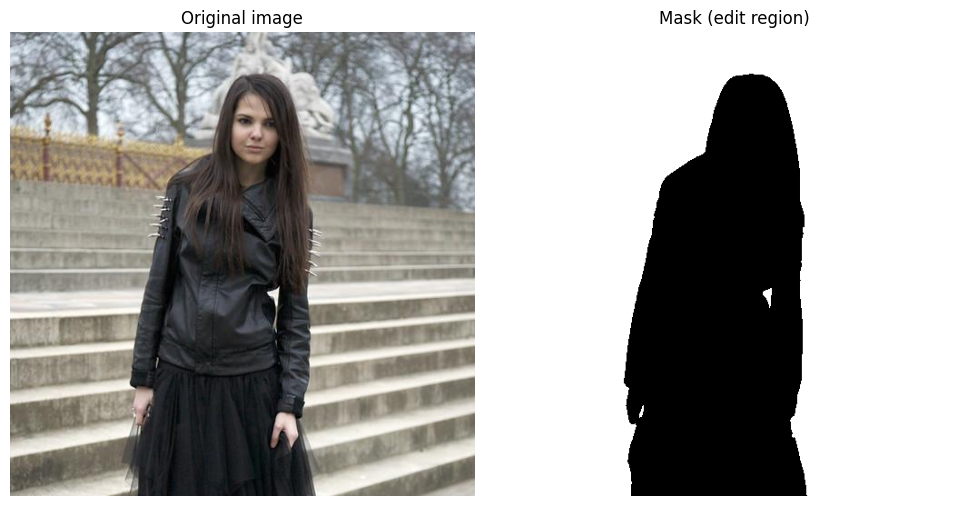

In [4]:
image = load_image_from_path(str(IMAGE_PATH))
image_mask = load_image_from_path(str(MASK_PATH))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original image")
ax[0].axis("off")
ax[1].imshow(image_mask)
ax[1].set_title("Mask (edit region)")
ax[1].axis("off")
plt.tight_layout()
plt.show()

## Load edited images (from outputs) and run edits for PhotoGuard / DiffusionGuard

In [5]:
set_seed_lib(SEED)

# 1) Edited (original) — load from outputs/edited_orig
edited_orig_path = EDITED_ORIG_DIR / f"{IMAGE_NAME}_edited_orig.png"
edited_orig_recovered = Image.open(edited_orig_path).convert("RGB")

# 2) Edited (PhotoGuard) — load pg_adv from outputs/pg_adv, run same edit
pg_adv_path = PG_ADV_DIR / f"{IMAGE_NAME}_pg_adv.png"
pg_adv = Image.open(pg_adv_path).convert("RGB")
pg_edited = immunization_mdl.edit_image(EDIT_PROMPT, pg_adv, image_mask)[0]
pg_edited_recovered = recover_image(pg_edited, pg_adv, image_mask, background=False)

# 3) Edited (DiffusionGuard) — load dg_adv from outputs/dg_adv, run same edit
dg_adv_path = DG_ADV_DIR / f"{IMAGE_NAME}_dg_adv.png"
dg_adv = Image.open(dg_adv_path).convert("RGB")
dg_edited = immunization_mdl.edit_image(EDIT_PROMPT, dg_adv, image_mask)[0]
dg_edited_recovered = recover_image(dg_edited, dg_adv, image_mask, background=False)

# 4) Edited (DiffVax) — load from outputs/edited_diffvax_adv
diffvax_edited_path = EDITED_DIFFVAX_DIR / f"{IMAGE_NAME}_edited_diffvax_adv.png"
diffvax_edited_recovered = Image.open(diffvax_edited_path).convert("RGB")

print("All four edited images loaded / computed.")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

All four edited images loaded / computed.


## Compare: Original edited vs PhotoGuard vs DiffusionGuard vs DiffVax

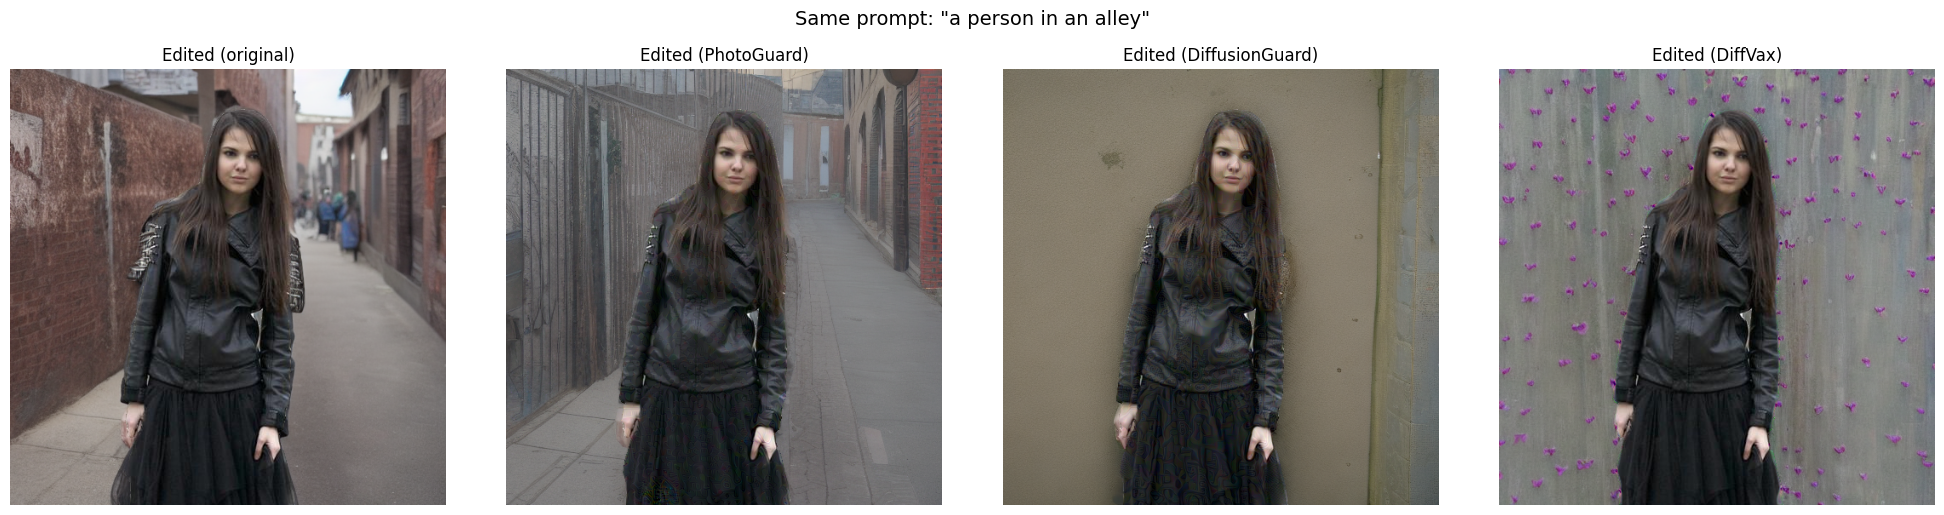

Comparison figure saved to /home/ozgurk2/tarik/DiffVaxUpdated/outputs/comparison_demo


In [6]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(edited_orig_recovered)
axes[0].set_title("Edited (original)", fontsize=12)
axes[0].axis("off")

axes[1].imshow(pg_edited_recovered)
axes[1].set_title("Edited (PhotoGuard)", fontsize=12)
axes[1].axis("off")

axes[2].imshow(dg_edited_recovered)
axes[2].set_title("Edited (DiffusionGuard)", fontsize=12)
axes[2].axis("off")

axes[3].imshow(diffvax_edited_recovered)
axes[3].set_title("Edited (DiffVax)", fontsize=12)
axes[3].axis("off")

plt.suptitle(f"Same prompt: \"{EDIT_PROMPT}\"", fontsize=14, y=1.02)
plt.tight_layout()
COMPARISON_DIR = OUTPUTS / "comparison_demo"
COMPARISON_DIR.mkdir(parents=True, exist_ok=True)
fig.savefig(COMPARISON_DIR / f"{IMAGE_NAME}_comparison.png", bbox_inches="tight", dpi=150)
plt.show()
print(f"Comparison figure saved to {COMPARISON_DIR}")

**Interpretation:** Each column uses the same inpainting prompt. **Edited (original)** shows the unprotected result. **PhotoGuard**, **DiffusionGuard**, and **DiffVax** show how each defense alters the edit when applied to their protected images (`outputs/pg_adv`, `outputs/dg_adv`, and DiffVax’s immunized image).